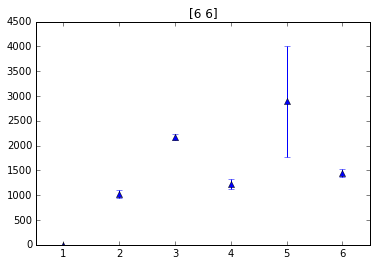

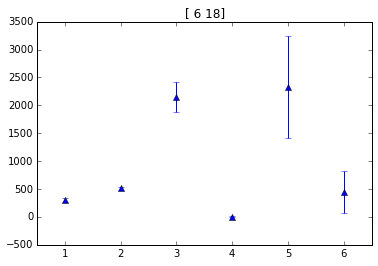

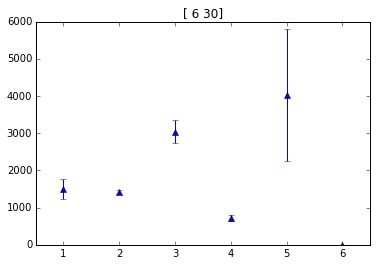

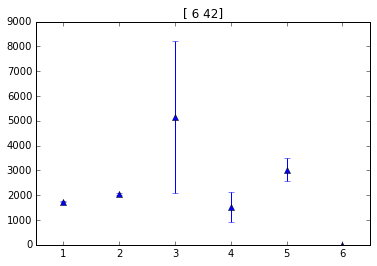

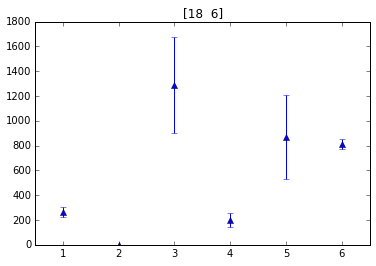

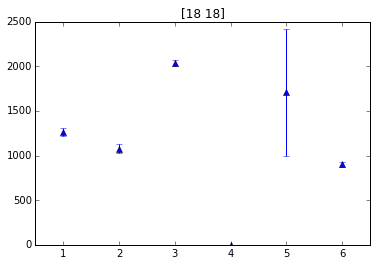

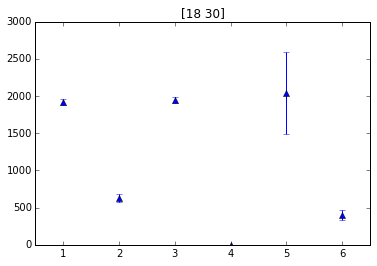

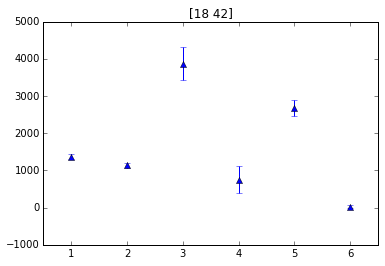

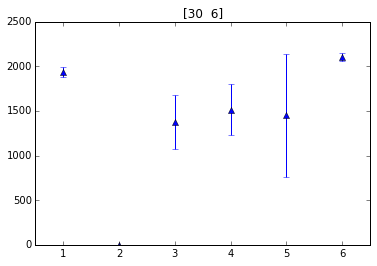

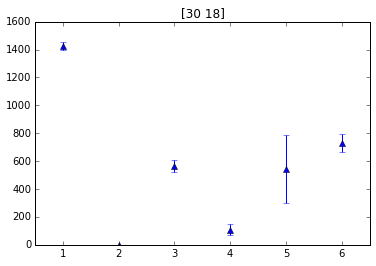

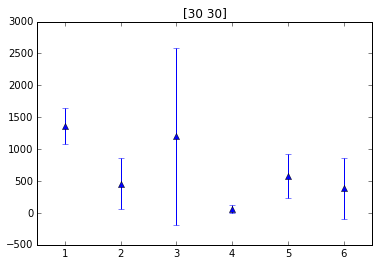

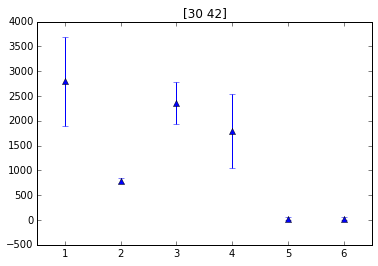

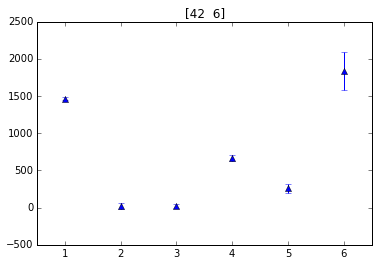

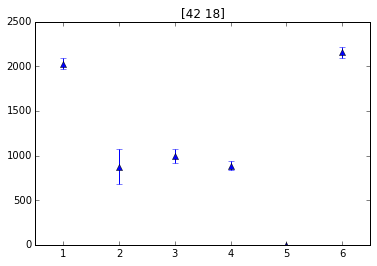

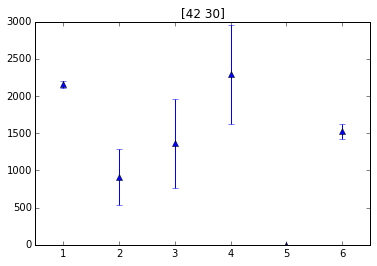

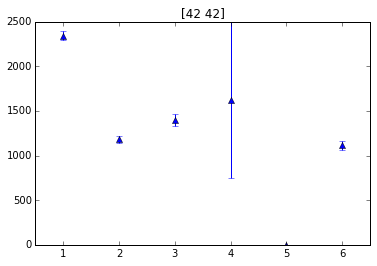

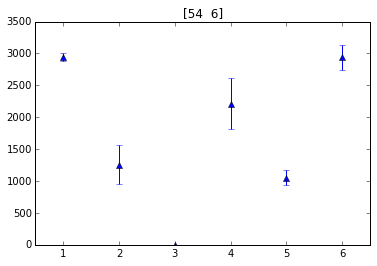

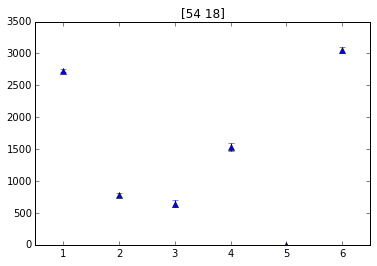

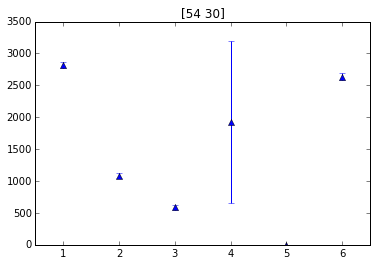

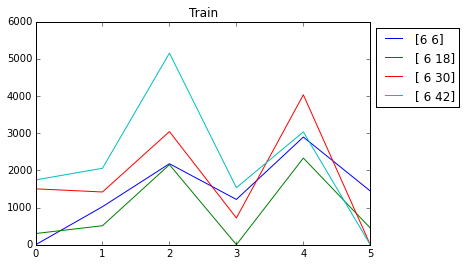

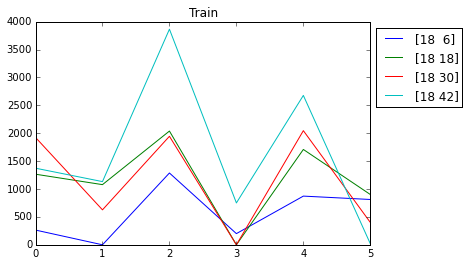

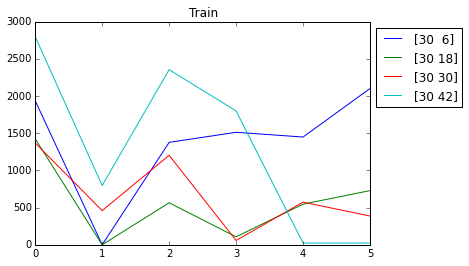

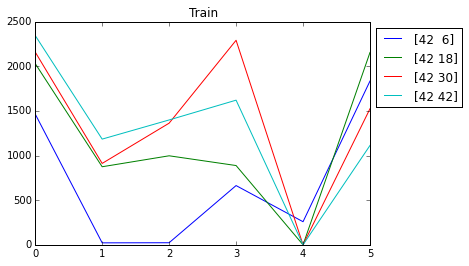

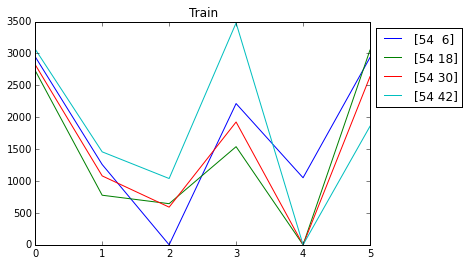

Train Error
            0   X   Y
1    3.084996   6   6
2    4.360477   6  18
3    2.503543   6  30
4    3.998490   6  42
5    8.079524  18   6
6    5.898015  18  18
7    4.644635  18  30
8   14.299352  18  42
9    0.868339  30   6
10   4.028435  30  18
11   0.797446  30  30
12  12.032358  30  42
13   4.164541  42   6
14   1.793049  42  18
15   0.995736  42  30
16   4.038379  42  42
17   8.166643  54   6
18   6.792805  54  18
19   9.392817  54  30
20   4.545266  54  42


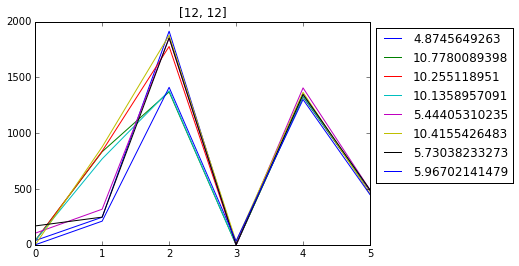

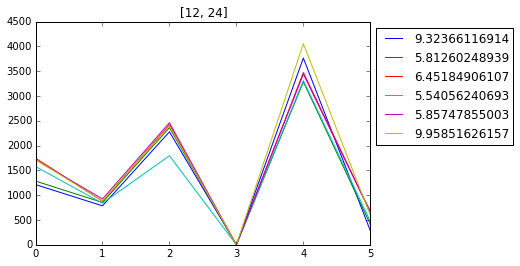

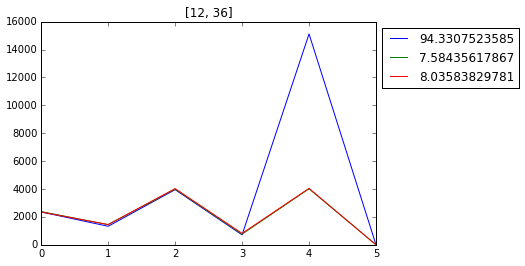

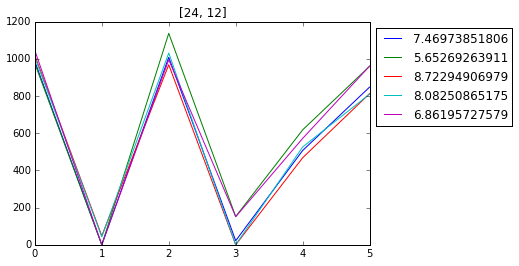

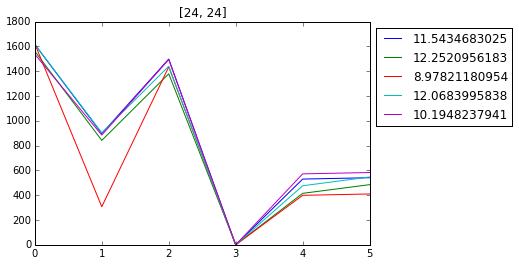

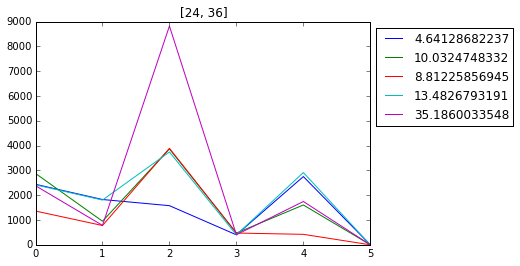

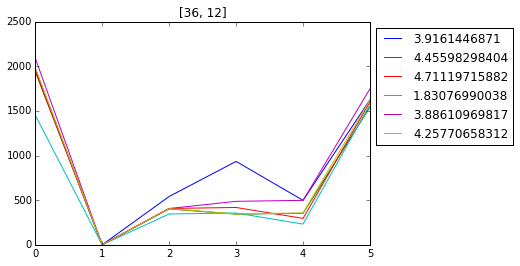

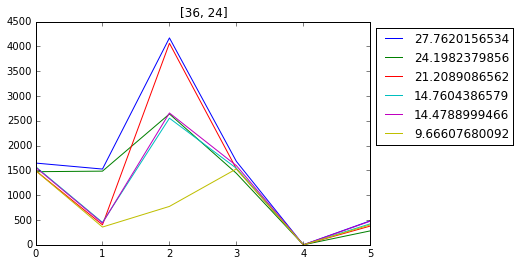

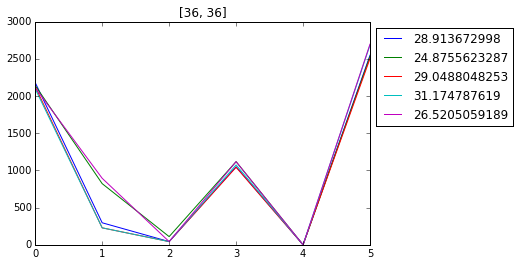

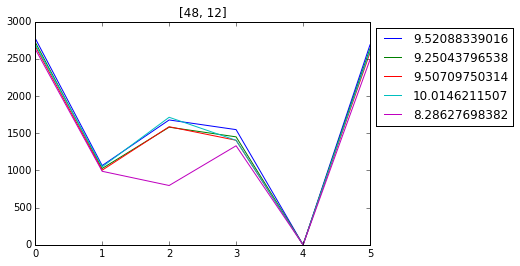

/home/asanso/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


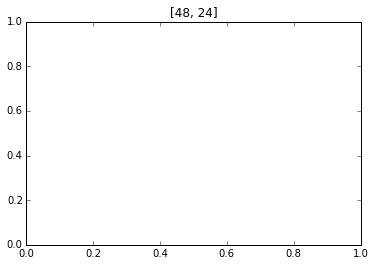

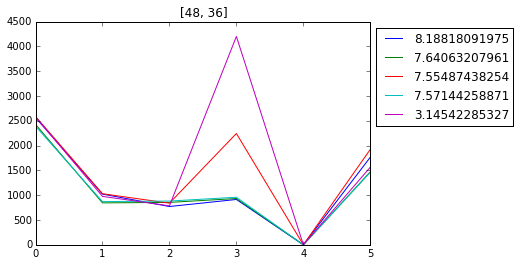

Test Error
           X_         Y_   X   Y      dists
0   14.308553  16.293247  12  12   4.874565
1   18.401630  20.670906  12  12  10.778009
2   16.302757  21.308799  12  12  10.255119
3   18.176911  20.036302  12  12  10.135896
4   14.754138  16.696002  12  12   5.444053
5   15.509394  21.806512  12  12  10.415543
6   15.253591  16.717142  12  12   5.730382
7   16.749648  15.611951  12  12   5.967021
8    6.070239  16.804960  12  24   9.323661
9    9.061325  18.984969  12  24   5.812602
10  10.657912  17.689283  12  24   6.451849
11  13.415846  18.643395  12  24   5.540562
12  10.533518  18.329067  12  24   5.857479
13   7.254158  15.245057  12  24   9.958516
14 -58.072918 -27.151223  12  36  94.330752
15   4.565683  34.498870  12  36   7.584356
16   4.132841  34.362164  12  36   8.035838
17  28.673597  17.827048  24  12   7.469739
18  27.711106  16.263875  24  12   5.652693
19  29.286012  18.938870  24  12   8.722949
20  28.573684  18.663960  24  12   8.082509
21  29.061878  16.632

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import re 
import itertools
import ast
import matplotlib.pyplot as plt


from sklearn.linear_model import  LinearRegression

positions = np.array([[6, 6],
                  [6, 18],
                  [6, 30],
                  [6, 42],
                  [18, 6],
                  [18, 18],
                  [18, 30],
                  [18, 42],
                  [30, 6],
                  [30, 18],
                  [30, 30],
                  [30, 42],
                  [42, 6],
                  [42, 18],
                  [42, 30],
                  [42, 42],
                  [54, 6],
                  [54, 18],
                  [54, 30],
                  [54, 42]])
numsensors = 6
numtrials = len(positions)

train_file = "../src/arduino/data/recolect_points_20160116_scrapping.txt"
test_file = "../src/arduino/data/mid_points_test_20160116_scrapping.txt"

pattern = "hit: {(.*)}"
hit_times = []
hit_values=[]
train_times = np.zeros([numtrials,numsensors])
train_values = np.zeros([numtrials,numsensors])
diff_pairs = numsensors*(numsensors-1)/2

##### TRAIN DATA AQUISITION
i = 0
with open(train_file) as fo:
    for line in fo:
        if line.startswith("("): # a new point is stored
            if len(hit_times)> 0 :
                array_time = np.array(hit_times)
                array_value = np.array(hit_values)
                plt.title(positions[i])
                plt.errorbar(range(1,numsensors+1),array_time.mean(axis=0), array_time.std(axis=0), linestyle='None', marker='^')
                plt.xlim([0.5, len(values) + 0.5])
                plt.show()
                train_times[i,:]= array_time.mean(axis=0)  #mean of hits in the same point
                train_values[i,:]= array_value.mean(axis=0)
                hit_times = [] #init hit_times list
                hit_values = [] #init hit_values
                i = i +1
        else:
            hit_re = re.match(pattern, line)
            if hit_re == None:
                continue
            sensors=hit_re.group(1).split(" ")
            times = []
            values = []
            for s in sensors[0:-1]:
                time,bd = s.split(":")
                times.append(int(time))
                values.append(int(bd))
            side = sensors[-1]
            hit_values.append(values)
            hit_times.append(times)


#ultim cas:  
mean_time = np.array(hit_times).mean(axis=0)
mean_value = np.array(hit_values).mean(axis=0)
train_times[i,:]= mean_time
train_values[i,:]= mean_value


# Matriu de diff per a train
train_diff= np.zeros([numtrials,diff_pairs])
for j in range(len(train_times)):
    i = 0
    for a in itertools.combinations(range(numsensors), 2):
        train_diff[j,i] = train_times[j,a[0]]-train_times[j,a[1]]
        i=i+1
        
train_df =  pd.DataFrame(train_times,index = range(1,numtrials+1) ,columns=range(1,numsensors+1))
train_y = pd.DataFrame(positions,columns=["X","Y"],index = range(1,numtrials+1))
train_df.join(train_y, how='inner')

diff_df = pd.DataFrame(train_diff,index = range(1,numtrials+1) ,columns=range(1,diff_pairs+1))
diff_df.join(train_y, how='inner')

for i,train in enumerate(train_values):
    plt.plot(train_times[i],label=positions[i])
    if (i % 4) == 3 :
        plt.title("Train")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()

    

##### Machine Learning Fit del train

l = LinearRegression()
l.fit(train_diff, positions)
dists_train = []
for i,train in enumerate(train_diff):
    dists_train.append(np.linalg.norm(l.predict(train)[0]-positions[i]))
   

print "Train Error"
print pd.DataFrame(dists_train, index = range(1,numtrials+1)).join(train_y, how='inner')


## Testing
dists_test = []
positions_test= []
predict_test=[]
current_position=[]
with open(test_file) as fo:
    for line in fo:    # For each line in test
        if line.startswith("["): # a new point is stored
            if (len(current_position)>0):
                plt.title(current_position)
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
                plt.show()
   
            current_position = ast.literal_eval(line[0:-2])
        else:  
            hit_re = re.match(pattern, line)
            if hit_re == None:
                continue
            sensors=hit_re.group(1).split(" ")
            test_times = []
            test_values = []
            for s in sensors[0:-1]:
                time,bd = s.split(":")
                test_times.append(int(time))
                test_values.append(int(bd))
            
            side = sensors[-1]
            test= np.zeros(diff_pairs)
            for i,a in enumerate(itertools.combinations(range(numsensors), 2)):
                test[i] = test_times[a[0]]-test_times[a[1]]
            predict = l.predict(test)[0]
            predict_test.append(predict)    
            dists_test.append(np.linalg.norm(predict-current_position))
            positions_test.append(current_position)
            plt.plot(test_times,label=dists_test[-1])
           
#last case
plt.title(current_position)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
        
print "Test Error"
print pd.DataFrame(predict_test,columns=["X_","Y_"]).join(pd.DataFrame(positions_test,columns=["X","Y"])).join(pd.DataFrame(dists_test,columns=["dists"]), how='inner')


